In [1]:
%matplotlib notebook
import sys, os, time
import collections
import copy
import csv
import os
from io import StringIO

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd

from torch.distributions import categorical
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
#from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
torch.cuda.is_available()

/tmp/ipykernel_37420/3623162318.py:13: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


True

# Table of contents

1. [RNN modules](#RNN-modules)
2. [Upload data](#Upload-data)
3. [Sentiment analysis](#Sentiment-analysis)
4. [Language model and sentence generation](#Language-model-and-sentence-generation)

In [2]:
print("GPU Model: %s" % torch.cuda.get_device_name(0))

GPU Model: Quadro RTX 5000


In [3]:
PADDING_TOKEN = 0

# RNN modules

[Back to top](#Table-of-contents)

In [4]:
class GRUCell(nn.Module):
    """
    Implementation of GRU cell from https://arxiv.org/pdf/1406.1078.pdf.
    """
    def __init__(self, input_size, hidden_size, bias=False):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        # Learnable weights and bias for `update gate`
        self.W_z = nn.Parameter(torch.Tensor(hidden_size, hidden_size + input_size))
        if bias:
            self.b_z = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('b_z', None)

        # Learnable weights and bias for `reset gate`
        self.W_r = nn.Parameter(torch.Tensor(hidden_size, hidden_size + input_size))
        if bias:
            self.b_r = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('b_r', None)

        # Learnable weights and bias for `output gate`
        self.W = nn.Parameter(torch.Tensor(hidden_size, hidden_size + input_size))
        if bias:
            self.b = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('b', None)

        self.reset_parameters()

    def forward(self, x, prev_state):
        if prev_state is None:
            batch = x.shape[0]
            prev_h = torch.zeros((batch, self.hidden_size), device=x.device)
        else:
            prev_h = prev_state

        concat_hx = torch.cat((prev_h, x), dim=1)
        z = torch.sigmoid(F.linear(concat_hx, self.W_z, self.b_z))
        r = torch.sigmoid(F.linear(concat_hx, self.W_r, self.b_r))
        h_tilde = torch.tanh(
            F.linear(torch.cat((r * prev_h, x), dim=1), self.W, self.b)
        )
        next_h = (1 - z) * prev_h + z * h_tilde
        return next_h

    def reset_parameters(self):
        sqrt_k = (1. / self.hidden_size)**0.5
        with torch.no_grad():
            for param in self.parameters():
                param.uniform_(-sqrt_k, sqrt_k)

    def extra_repr(self):
        return 'input_size={}, hidden_size={}, bias={}'.format(
            self.input_size, self.hidden_size, self.bias is not True
        )

    def count_parameters(self):
        print('Total Parameters: %d' %
            sum(p.numel() for p in self.parameters() if p.requires_grad)
        )


In [5]:
class LSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size, bias=False):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        # Learnable weights and bias for `forget gate`
        self.W_f = nn.Parameter(torch.Tensor(hidden_size, hidden_size + input_size))
        if bias:
            self.b_f = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('b_f', None)

        # Learnable weights and bias for `input gate`
        self.W_i = nn.Parameter(torch.Tensor(hidden_size, hidden_size + input_size))
        if bias:
            self.b_i = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('b_i', None)

        # Learnable weights and bias for `candidate cell state`
        self.W_c = nn.Parameter(torch.Tensor(hidden_size, hidden_size + input_size))
        if bias:
            self.b_c = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('b_c', None)

        # Learnable weights and bias for `output gate`
        self.W_o = nn.Parameter(torch.Tensor(hidden_size, hidden_size + input_size))
        if bias:
            self.b_o = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('b_o', None)

        self.reset_parameters()

    def forward(self, x, prev_state):
        if prev_state is None:
            batch = x.shape[0]
            prev_h = torch.zeros((batch, self.hidden_size), device=x.device)
            prev_c = torch.zeros((batch, self.hidden_size), device=x.device)
        else:
            prev_h, prev_c = prev_state

        concat_hx = torch.cat((prev_h, x), dim=1)
        f = torch.sigmoid(F.linear(concat_hx, self.W_f, self.b_f))
        i = torch.sigmoid(F.linear(concat_hx, self.W_i, self.b_i))
        o = torch.sigmoid(F.linear(concat_hx, self.W_o, self.b_o))

        c_tilde = torch.tanh(F.linear(concat_hx, self.W_c, self.b_c))

        next_c = f * prev_c + i * c_tilde
        next_h = o * torch.tanh(next_c)
    
        return next_h, next_c

    def reset_parameters(self):
        sqrt_k = (1. / self.hidden_size)**0.5
        with torch.no_grad():
            for param in self.parameters():
                param.uniform_(-sqrt_k, sqrt_k)
        return

    def extra_repr(self):
        return 'input_size={}, hidden_size={}, bias={}'.format(
            self.input_size, self.hidden_size, self.bias is not True
        )

    def count_parameters(self):
        print('Total Parameters: %d' %
            sum(p.numel() for p in self.parameters() if p.requires_grad)
        )


In [6]:
class PeepholedLSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size, bias=False):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        # Learnable weights and bias for `forget gate`
        self.W_f = nn.Parameter(torch.Tensor(hidden_size, 2*hidden_size + input_size))
        if bias:
            self.b_f = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('b_f', None)

        # Learnable weights and bias for `input gate`
        self.W_i = nn.Parameter(torch.Tensor(hidden_size, 2*hidden_size + input_size))
        if bias:
            self.b_i = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('b_i', None)

        # Learnable weights and bias for `candidate cell state`
        self.W_c = nn.Parameter(torch.Tensor(hidden_size, hidden_size + input_size))
        if bias:
            self.b_c = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('b_c', None)

        # Learnable weights and bias for `output gate`
        self.W_o = nn.Parameter(torch.Tensor(hidden_size, 2*hidden_size + input_size))
        if bias:
            self.b_o = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('b_o', None)
            
        self.reset_parameters()

    def forward(self, x, prev_state):
        if prev_state is None:
            batch = x.shape[0]
            prev_h = torch.zeros((batch, self.hidden_size), device=x.device)
            prev_c = torch.zeros((batch, self.hidden_size), device=x.device)
        else:
            prev_h, prev_c = prev_state

        concat_chx = torch.cat((prev_c, prev_h, x), dim=1) 
        f = torch.sigmoid(F.linear(concat_chx, self.W_f, self.b_f))
        i = torch.sigmoid(F.linear(concat_chx, self.W_i, self.b_i))

        concat_hx = torch.cat((prev_h, x), dim=1)
        c_tilde = torch.tanh(F.linear(concat_hx, self.W_c, self.b_c))
    
        next_c = f * prev_c + i * c_tilde
        
        concat_Chx = torch.cat((next_c, prev_h, x), dim=1)
        o = torch.sigmoid(F.linear(concat_Chx, self.W_o, self.b_o))
        
        next_h = o * torch.tanh(next_c)

        return next_h, next_c

    def reset_parameters(self):
        sqrt_k = (1. / self.hidden_size)**0.5
        with torch.no_grad():
            for param in self.parameters():
                param.uniform_(-sqrt_k, sqrt_k)
        return

    def extra_repr(self):
        return 'input_size={}, hidden_size={}, bias={}'.format(
            self.input_size, self.hidden_size, self.bias is not True
        )

    def count_parameters(self):
        print('Total Parameters: %d' %
            sum(p.numel() for p in self.parameters() if p.requires_grad)
        )


In [7]:
class CoupledLSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size, bias=False):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        # Learnable weights and bias for `forget gate`
        self.W_f = nn.Parameter(torch.Tensor(hidden_size, hidden_size + input_size))
        if bias:
            self.b_f = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('b_f', None)

        # Learnable weights and bias for `candidate cell state`
        self.W_c = nn.Parameter(torch.Tensor(hidden_size, hidden_size + input_size))
        if bias:
            self.b_c = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('b_c', None)

        # Learnable weights and bias for `output gate`
        self.W_o = nn.Parameter(torch.Tensor(hidden_size, hidden_size + input_size))
        if bias:
            self.b_o = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('b_o', None)
            
        self.reset_parameters()

    def forward(self, x, prev_state):
        if prev_state is None:
            batch = x.shape[0]
            prev_h = torch.zeros((batch, self.hidden_size), device=x.device)
            prev_c = torch.zeros((batch, self.hidden_size), device=x.device)
        else:
            prev_h, prev_c = prev_state

        concat_hx = torch.cat((prev_h, x), dim=1)
        f = torch.sigmoid(F.linear(concat_hx, self.W_f, self.b_f))
        o = torch.sigmoid(F.linear(concat_hx, self.W_o, self.b_o))

        c_tilde = torch.tanh(F.linear(concat_hx, self.W_c, self.b_c))

        next_c = f * prev_c + (1 - f) * c_tilde
        next_h = o * torch.tanh(next_c)
    
        return next_h, next_c

    def reset_parameters(self):
        sqrt_k = (1. / self.hidden_size)**0.5
        with torch.no_grad():
            for param in self.parameters():
                param.uniform_(-sqrt_k, sqrt_k)
        return

    def extra_repr(self):
        return 'input_size={}, hidden_size={}, bias={}'.format(
            self.input_size, self.hidden_size, self.bias is not True
        )

    def count_parameters(self):
        print('Total Parameters: %d' %
            sum(p.numel() for p in self.parameters() if p.requires_grad)
        )


In [8]:
RNN_MODULES = {
    'gru': GRUCell,
    'lstm': LSTMCell,
    'peepholed_lstm': PeepholedLSTMCell,
    'coupled_lstm': CoupledLSTMCell,
}

for name, rnn_type in RNN_MODULES.items():
    print(name, end='\n  ')
    rnn_type(input_size=128, hidden_size=100, bias=True).count_parameters()

gru
  Total Parameters: 68700
lstm
  Total Parameters: 91600
peepholed_lstm
  Total Parameters: 121600
coupled_lstm
  Total Parameters: 68700


LSTM has more parameters than GRU due to the additional gate, whereas peepholed LSTM has even more still do to the additional weights that connect the cell state to each of the gates. On the otherhand, coupled LSTM has the same number of parameters as GRU because it has the same number of gates and no extra connections.

# Upload data

[Back to top](#Table-of-contents)

In [9]:
#uploaded = files.upload()

#for fn in uploaded.keys():
#    print('User uploaded file "{name}" with length {length} bytes'.format(
#        name=fn, length=len(uploaded[fn]))
#    )

def read_file(fname):
    with open(fname, 'rb') as f:
        return f.read()

uploaded = {n: read_file(n) for n in ['imdb_train.csv', 'imdb_test.csv', 'shakespeare.txt']}

In [10]:
train_dataset_text = uploaded['imdb_train.csv']
test_dataset_text = uploaded['imdb_test.csv']
shakespeare_text = uploaded['shakespeare.txt']

# Sentiment analysis

[Back to top](#Table-of-contents)

In [11]:
### Hyperparameters for training (previously defined in FLAGS)
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0
BATCH_SIZE = 4096
EPOCHS = 100
GRADIENT_CLIP_NORM = 1.0

### Hyperparameters for sentence analysis model
EMBEDDING_DIM = 128
HIDDEN_SIZE = 100
REVIEW_MAX_LENGTH = 200
VOCABULARY_MIN_COUNT = 100
VOCABULARY_MAX_SIZE = 20000
RNN_MODULE = 'gru'    # You need to try 'lstm', 'peepholed_lstm', 'coupled_lstm'

In [12]:
class IMDBReviewDataset(Dataset):

    def __init__(
        self,
        csv_text,
        vocabulary=None,
        vocab_min_count=10,
        vocab_max_size=None,
        review_max_length=200
    ):
        self.csv_text = csv_text
        self.vocab_min_count = vocab_min_count
        self.vocab_max_size = vocab_max_size
        self.review_max_length = review_max_length - 2

        self.data = []

        encoded_text = csv_text.strip().decode(encoding='utf-8')
        fp = StringIO(encoded_text)
        reader = csv.DictReader(fp, delimiter=',')
        for row in reader:
            self.data.append((
                row['review'].split(' ')[:review_max_length],
                int(row['sentiment'] == 'positive')
            ))
        fp.close()

        if vocabulary is not None:
            print('Using external vocabulary - vocab-related configs ignored.')
            self.vocabulary = vocabulary
        else:
            self.vocabulary = self._build_vocabulary()

        self.word2index = {w: i for (i, w) in enumerate(self.vocabulary)}
        self.index2word = {i: w for (i, w) in enumerate(self.vocabulary)}
        self.oov_token_id = self.word2index['OOV_TOKEN']
        self.pad_token_id = self.word2index['PAD_TOKEN']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        review, label = self.data[index]
        review = ['BEGIN_TOKEN'] + review + ['END_TOKEN']
        token_ids = [self.word2index.get(w, self.oov_token_id) for w in review]
        return token_ids, label

    def _build_vocabulary(self):
        special_tokens = ['PAD_TOKEN', 'BEGIN_TOKEN', 'OOV_TOKEN', 'END_TOKEN']

        counter = collections.Counter()
        for review, _ in self.data:
            counter.update(review)

        vocab = counter.most_common(self.vocab_max_size - 4)
        if self.vocab_min_count is not None:
            vocab_tokens = [w for (w, c) in vocab if c >= self.vocab_min_count]
        else:
            vocab_tokens, _ = zip(vocab)

        return special_tokens + vocab_tokens

    def get_vocabulary(self):
        return self.vocabulary

    def print_statistics(self):
        reviews, labels = zip(*self.data)
        lengths = [len(x) for x in reviews]
        positive = np.sum(labels)
        negative = len(labels) - positive
        print('Total instances: %d, positive: %d, negative: %d' %
            (len(self.data), positive, negative)
        )
        print('Review lengths: max: %d, min: %d, mean: %d, median: %d' %
            (max(lengths), min(lengths), np.mean(lengths), np.median(lengths))
        )
        print('Vocabulary size: %d' % len(self.vocabulary))


def imdb_collate_fn(batch_data, padding_token_id=PADDING_TOKEN):
    """Padding variable-length sequences."""
    batch_tokens, batch_labels = zip(*batch_data)
    lengths = [len(x) for x in batch_tokens]
    max_length = max(lengths)

    padded_tokens = []
    for tokens, length in zip(batch_tokens, lengths):
        padded_tokens.append(tokens + [padding_token_id] * (max_length - length))

    padded_tokens = torch.tensor(padded_tokens, dtype=torch.int64)
    lengths = torch.tensor(lengths, dtype=torch.int64)
    labels = torch.tensor(batch_labels, dtype=torch.int64)

    return padded_tokens, lengths, labels


train_dataset = IMDBReviewDataset(
    csv_text=train_dataset_text,
    vocab_min_count=100,
    vocab_max_size=20000,
    review_max_length=200
)
train_dataset.print_statistics()
train_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    collate_fn=imdb_collate_fn
)
vocabulary = train_dataset.get_vocabulary()
[vocabulary[i] for i in train_dataset[0][0]]

Total instances: 45000, positive: 22500, negative: 22500
Review lengths: max: 200, min: 8, mean: 168, median: 198
Vocabulary size: 4835


['BEGIN_TOKEN',
 'I',
 'have',
 'OOV_TOKEN',
 'the',
 'various',
 'OOV_TOKEN',
 'and',
 'thriller',
 'type',
 'movies',
 'this',
 'summer',
 'but',
 'was',
 'so',
 'disappointed',
 'about',
 'this',
 'particular',
 'film',
 '.',
 'While',
 'some',
 'people',
 'walked',
 'out',
 'of',
 'the',
 'film',
 ',',
 'I',
 'decided',
 'to',
 'stay',
 ',',
 'only',
 'to',
 'laugh',
 'along',
 'with',
 'the',
 'other',
 'OOV_TOKEN',
 'at',
 'the',
 'acting',
 ',',
 'lack',
 'of',
 'suspense',
 ',',
 'ridiculous',
 'ending',
 'and',
 'difficult',
 'to',
 'follow',
 'story',
 'line',
 '.',
 'I',
 'found',
 'myself',
 'almost',
 'as',
 'confused',
 'as',
 'the',
 'main',
 'character',
 'in',
 'the',
 'film',
 '.',
 'The',
 'only',
 'redeeming',
 'quality',
 'of',
 'the',
 'film',
 'was',
 'the',
 'soundtrack',
 '.',
 'This',
 'is',
 'one',
 'of',
 'those',
 'OOV_TOKEN',
 'star',
 'films',
 'which',
 'they',
 'later',
 'regret',
 'doing',
 '.',
 'In',
 'OOV_TOKEN',
 ',',
 'I',
 'would',
 "n't",
 'even

In [13]:
class SentimentClassification(nn.Module):

    def __init__(
        self,
        vocabulary_size,
        embedding_dim,
        rnn_module,
        hidden_size,
        bias=False
    ):
        super().__init__()
        self.vocabulary_size = vocabulary_size
        self.rnn_module = rnn_module
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.bias = bias

        self.embedding = nn.Embedding(
            num_embeddings=vocabulary_size,
            embedding_dim=embedding_dim,
            padding_idx=PADDING_TOKEN
        )
        self.rnn_model = self.rnn_module(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            bias=bias
        )
        self.classifier = nn.Linear(hidden_size, 2)

    def forward(self, batch_reviews, batch_lengths):
        data = self.embedding(batch_reviews)

        state = None
        batch_size, total_steps, _ = data.shape
        full_outputs = []
        for step in range(total_steps):
            next_state = self.rnn_model(data[:, step, :], state)
            if isinstance(next_state, tuple):
                h, c = next_state
                full_outputs.append(h)
            else:
                full_outputs.append(next_state)
            state = next_state

        full_outputs = torch.stack(full_outputs, dim=1)
        outputs = full_outputs[torch.arange(batch_size), batch_lengths - 1, :]
        logits = self.classifier(outputs)
        return logits


In [14]:
class TrainingPlot(object):
    '''
    Interactive training plot.
    '''
    def __init__(self):
        
        # create subplots for loss and accuracy
        self.fig, ax = plt.subplots(1, 2, figsize=(8,4))
        ax[0].set_ylabel('loss')
        ax[1].set_ylabel('accuracy')
        for ax_ in ax:
            ax_.set_axisbelow(True)
            ax_.grid(linestyle=':')
            ax_.set_xlabel('epoch')
        self.fig.tight_layout()
        
        # store data and artists for interactive ploting
        self.data = pd.DataFrame(columns=['iter', 'phase', 'loss', 'accy'])

        self.train_loss_line = ax[0].plot([], [], label='train')[0]
        self.test_loss_line  = ax[0].plot([], [], label='test')[0]
        self.train_accy_line = ax[1].plot([], [], label='train')[0]
        self.test_accy_line  = ax[1].plot([], [], label='test')[0]
        
    def draw(self, pad=1e-8):
        ax = self.fig.get_axes()
        ax[0].set_xlim(0, self.data.iter.max() * 1.1 + pad)
        ax[0].set_ylim(0, self.data.loss.max() * 1.1 + pad)
        ax[1].set_xlim(0, self.data.iter.max() * 1.1 + pad)
        ax[1].set_ylim(0, self.data.accy.max() * 1.1 + pad)
        self.fig.canvas.draw()
        
    def update_train(self, iteration, loss, accy):
        self.data.loc[len(self.data)] = [iteration, 'train', loss, accy]
        
        data = self.data.groupby(['phase', 'iter']).mean()
        train = data.loc['train'].reset_index()
        if isinstance(train, pd.Series): # need > 1 rows
            return
        
        self.train_loss_line.set_xdata(train.iter)
        self.train_loss_line.set_ydata(train.loss)

        self.train_accy_line.set_xdata(train.iter)
        self.train_accy_line.set_ydata(train.accy)

        self.draw()
        
    def update_test(self, iteration, loss, accy):
        self.data.loc[len(self.data)] = [iteration, 'test', loss, accy]
        
        data = self.data.groupby(['phase', 'iter']).mean()
        test = data.loc['test'].reset_index()
        if isinstance(test, pd.Series): # need > 1 rows
            return
        
        self.test_loss_line.set_xdata(test.iter)
        self.test_loss_line.set_ydata(test.loss) 
        
        self.test_accy_line.set_xdata(test.iter)
        self.test_accy_line.set_ydata(test.accy)
        
        self.draw()

In [15]:
def imdb_trainer(
    vocabulary_min_count,
    vocabulary_max_size,
    review_max_length,
    batch_size,
    rnn_module,
    embedding_dim,
    hidden_size,
    learning_rate,
    weight_decay,
    epochs,
    gradient_clip_norm,
    device='cuda'
):
    train_dataset = IMDBReviewDataset(
        csv_text=train_dataset_text,
        vocab_min_count=vocabulary_min_count,
        vocab_max_size=vocabulary_max_size,
        review_max_length=review_max_length
    )
    train_dataset.print_statistics()
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        collate_fn=imdb_collate_fn
    )
    vocabulary = train_dataset.get_vocabulary()

    # Validation dataset should use the same vocabulary as the training set.
    val_dataset = IMDBReviewDataset(
        csv_text=test_dataset_text,
        vocabulary=vocabulary,
        review_max_length=review_max_length
    )
    val_dataset.print_statistics()
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=1,
        collate_fn=imdb_collate_fn
    )

    best_model = None
    best_acc = 0.0

    full_train_loss = []
    full_train_accuracy = []
    full_val_loss = []
    full_val_accuracy = []

    model = SentimentClassification(
        vocabulary_size=len(vocabulary),
        embedding_dim=embedding_dim,
        rnn_module=RNN_MODULES[rnn_module],
        hidden_size=hidden_size
    ).to(device)

    print('Model Architecture:\n%s' % model)

    criterion = nn.CrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )
    plot = TrainingPlot()

    for epoch in range(epochs):
        for phase in ('train', 'eval'):
            if phase == 'train':
                model.train()
                dataset = train_dataset
                data_loader = train_loader
            else:
                model.eval()
                dataset = val_dataset
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            print(f'{phase} phase')
            for step, (reviews, lengths, labels) in enumerate(tqdm(data_loader, file=sys.stdout)):
                reviews = reviews.to(device)
                lengths = lengths.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(reviews, lengths)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    assert torch.isfinite(loss), loss.item()

                    if phase == 'train':
                        loss.backward()

                        # RNN model is easily getting exploded gradients, thus we perform
                        # gradients clipping to mitigate this issue.
                        nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_norm)
                        optimizer.step()

                running_loss += loss.item() * reviews.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataset)
            epoch_acc = running_corrects.double().item() / len(dataset)
            if phase == 'train':
                full_train_accuracy.append(epoch_acc)
                full_train_loss.append(epoch_loss)
                plot.update_train(epoch, epoch_loss, epoch_acc)
            elif phase == 'eval':
                full_val_accuracy.append(epoch_acc)
                full_val_loss.append(epoch_loss)
                plot.update_test(epoch, epoch_loss, epoch_acc)

            print(f'[Epoch {epoch+1:d}] {phase} accuracy: {epoch_acc:.4f}, loss: {epoch_loss:.4f}')

            if phase == 'eval':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model = copy.deepcopy(model).cpu().state_dict()

    state_dict = {"model": best_model, "vocabulary": vocabulary}
    print(f"Best validation accuracy: {best_acc:.4f}")
    logs = (full_train_loss, full_train_accuracy, full_val_loss, full_val_accuracy)

    return state_dict, logs


Total instances: 45000, positive: 22500, negative: 22500
Review lengths: max: 200, min: 8, mean: 168, median: 198
Vocabulary size: 4835
Using external vocabulary - vocab-related configs ignored.
Total instances: 5000, positive: 2500, negative: 2500
Review lengths: max: 200, min: 11, mean: 167, median: 195
Vocabulary size: 4835
Model Architecture:
SentimentClassification(
  (embedding): Embedding(4835, 128, padding_idx=0)
  (rnn_model): GRUCell(input_size=128, hidden_size=100, bias=True)
  (classifier): Linear(in_features=100, out_features=2, bias=True)
)


<IPython.core.display.Javascript object>


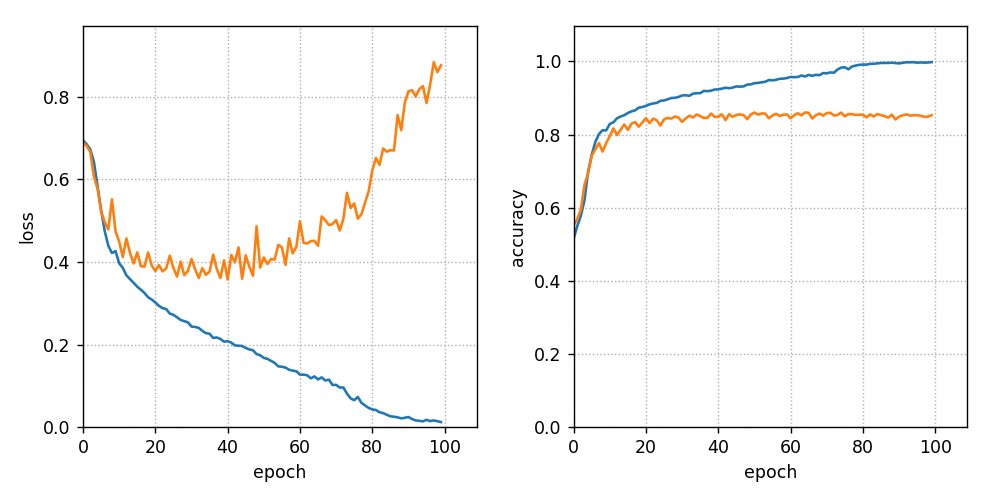

train phase
100%|██████████| 11/11 [00:32<00:00,  2.95s/it]
[Epoch 1] train accuracy: 0.5155, loss: 0.6939
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.49it/s]
[Epoch 1] eval accuracy: 0.5514, loss: 0.6885
train phase
100%|██████████| 11/11 [00:20<00:00,  1.90s/it]
[Epoch 2] train accuracy: 0.5496, loss: 0.6848
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.60it/s]
[Epoch 2] eval accuracy: 0.5688, loss: 0.6808
train phase
100%|██████████| 11/11 [00:20<00:00,  1.90s/it]
[Epoch 3] train accuracy: 0.5780, loss: 0.6728
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.67it/s]
[Epoch 3] eval accuracy: 0.5950, loss: 0.6663
train phase
100%|██████████| 11/11 [00:20<00:00,  1.89s/it]
[Epoch 4] train accuracy: 0.6205, loss: 0.6427
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.52it/s]
[Epoch 4] eval accuracy: 0.6630, loss: 0.6068
train phase
100%|██████████| 11/11 [00:20<00:00,  1.90s/it]
[Epoch 5] train accuracy: 0.6988, loss: 0.5846
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.60it

100%|██████████| 2/2 [00:01<00:00,  1.83it/s]
[Epoch 39] eval accuracy: 0.8574, loss: 0.3609
train phase
100%|██████████| 11/11 [00:20<00:00,  1.89s/it]
[Epoch 40] train accuracy: 0.9230, loss: 0.2069
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.62it/s]
[Epoch 40] eval accuracy: 0.8484, loss: 0.4036
train phase
100%|██████████| 11/11 [00:20<00:00,  1.89s/it]
[Epoch 41] train accuracy: 0.9237, loss: 0.2080
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.63it/s]
[Epoch 41] eval accuracy: 0.8486, loss: 0.3574
train phase
100%|██████████| 11/11 [00:20<00:00,  1.90s/it]
[Epoch 42] train accuracy: 0.9257, loss: 0.2045
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.47it/s]
[Epoch 42] eval accuracy: 0.8554, loss: 0.4164
train phase
100%|██████████| 11/11 [00:20<00:00,  1.90s/it]
[Epoch 43] train accuracy: 0.9281, loss: 0.1979
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.54it/s]
[Epoch 43] eval accuracy: 0.8394, loss: 0.3987
train phase
100%|██████████| 11/11 [00:20<00:00,  1.89s/it]

100%|██████████| 11/11 [00:20<00:00,  1.90s/it]
[Epoch 78] train accuracy: 0.9862, loss: 0.0588
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.75it/s]
[Epoch 78] eval accuracy: 0.8556, loss: 0.5153
train phase
100%|██████████| 11/11 [00:20<00:00,  1.89s/it]
[Epoch 79] train accuracy: 0.9887, loss: 0.0525
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.64it/s]
[Epoch 79] eval accuracy: 0.8538, loss: 0.5432
train phase
100%|██████████| 11/11 [00:20<00:00,  1.88s/it]
[Epoch 80] train accuracy: 0.9906, loss: 0.0466
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.72it/s]
[Epoch 80] eval accuracy: 0.8544, loss: 0.5707
train phase
100%|██████████| 11/11 [00:20<00:00,  1.89s/it]
[Epoch 81] train accuracy: 0.9914, loss: 0.0429
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.75it/s]
[Epoch 81] eval accuracy: 0.8544, loss: 0.6214
train phase
100%|██████████| 11/11 [00:20<00:00,  1.89s/it]
[Epoch 82] train accuracy: 0.9912, loss: 0.0415
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.68it/s]

In [16]:
%%time
default_config = {
    'vocabulary_min_count': 100,
    'vocabulary_max_size': 20000,
    'review_max_length': 200,
    'batch_size': 4096,
    'rnn_module': 'gru',
    'embedding_dim': 128,
    'hidden_size': 100,
    'learning_rate': 1e-3,
    'weight_decay': 0,
    'epochs': 100,
    'gradient_clip_norm': 1.0,
}
state_dict, logs = imdb_trainer(**default_config)

In [17]:
def run_experiment(eval_fn, base_config, var_name, var_values):
    
    print(f'Running {var_name} experiment')
    print(f'{len(var_values)} trials: {var_values}')
    
    results = pd.DataFrame(columns=[var_name, 'phase', 'loss', 'accy'])
    results.set_index([var_name, 'phase'], inplace=True)
    
    for value in var_values:
        print(f'Setting {var_name} = {value}')

        config = base_config.copy()
        config[var_name] = value      
        print(config)

        t0 = time.time()
        best_model, (train_loss, train_accy, val_loss, val_accy) = eval_fn(**config)
        dt = time.time() - t0

        results.loc[(value, 'train'), 'loss'] = train_loss[-1]
        results.loc[(value, 'train'), 'accy'] = train_accy[-1]
        results.loc[(value, 'test'), 'loss']  = val_loss[-1]
        results.loc[(value, 'test'), 'accy']  = val_accy[-1]
        results.loc[(value, 'train'), 'time'] = dt / config['epochs']
    
    fig, ax = plt.subplots(1, 3, figsize=(8, 4))
    sns.barplot(results, x=var_name, y='loss', hue='phase', ax=ax[0])
    sns.barplot(results, x=var_name, y='accy', hue='phase', ax=ax[1])
    sns.barplot(results, x=var_name, y='time', ax=ax[2])
    for i, ax_ in enumerate(ax):
        if i < 2:
            ax_.legend(loc='lower right')
        ax_.set_axisbelow(True)
        ax_.grid(linestyle=':')
    
    fig.tight_layout()
    fig.canvas.draw()
    
    return results.unstack(1)

Running rnn_module experiment
4 trials: ['gru', 'lstm', 'peepholed_lstm', 'coupled_lstm']
Setting rnn_module = gru
{'vocabulary_min_count': 100, 'vocabulary_max_size': 20000, 'review_max_length': 200, 'batch_size': 4096, 'rnn_module': 'gru', 'embedding_dim': 128, 'hidden_size': 100, 'learning_rate': 0.001, 'weight_decay': 0, 'epochs': 40, 'gradient_clip_norm': 1.0}
Total instances: 45000, positive: 22500, negative: 22500
Review lengths: max: 200, min: 8, mean: 168, median: 198
Vocabulary size: 4835
Using external vocabulary - vocab-related configs ignored.
Total instances: 5000, positive: 2500, negative: 2500
Review lengths: max: 200, min: 11, mean: 167, median: 195
Vocabulary size: 4835
Model Architecture:
SentimentClassification(
  (embedding): Embedding(4835, 128, padding_idx=0)
  (rnn_model): GRUCell(input_size=128, hidden_size=100, bias=True)
  (classifier): Linear(in_features=100, out_features=2, bias=True)
)


<IPython.core.display.Javascript object>


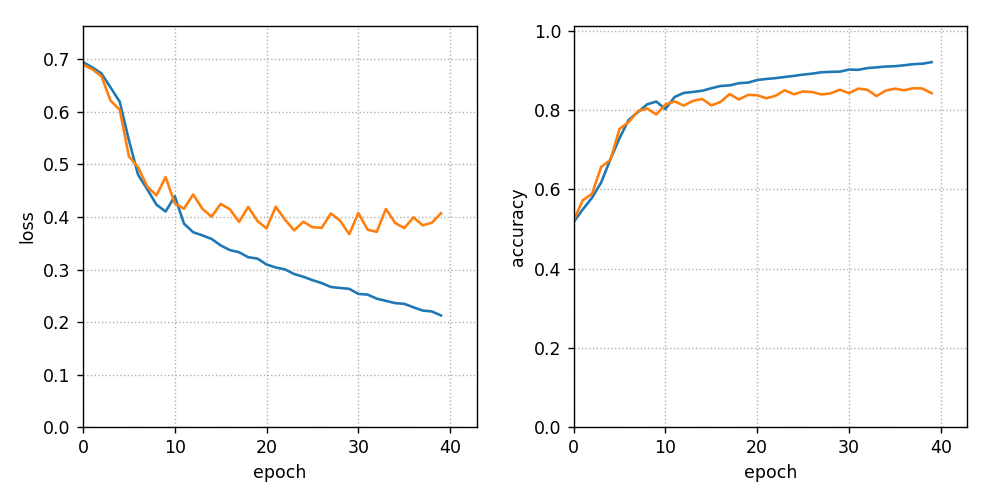

train phase
100%|██████████| 11/11 [00:27<00:00,  2.49s/it]
[Epoch 1] train accuracy: 0.5173, loss: 0.6946
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.63it/s]
[Epoch 1] eval accuracy: 0.5214, loss: 0.6901
train phase
100%|██████████| 11/11 [00:21<00:00,  1.91s/it]
[Epoch 2] train accuracy: 0.5491, loss: 0.6847
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.78it/s]
[Epoch 2] eval accuracy: 0.5722, loss: 0.6811
train phase
100%|██████████| 11/11 [00:20<00:00,  1.90s/it]
[Epoch 3] train accuracy: 0.5784, loss: 0.6733
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.78it/s]
[Epoch 3] eval accuracy: 0.5882, loss: 0.6680
train phase
100%|██████████| 11/11 [00:20<00:00,  1.90s/it]
[Epoch 4] train accuracy: 0.6171, loss: 0.6464
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.56it/s]
[Epoch 4] eval accuracy: 0.6562, loss: 0.6214
train phase
100%|██████████| 11/11 [00:20<00:00,  1.90s/it]
[Epoch 5] train accuracy: 0.6752, loss: 0.6193
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.70it

100%|██████████| 2/2 [00:01<00:00,  1.54it/s]
[Epoch 39] eval accuracy: 0.8540, loss: 0.3890
train phase
100%|██████████| 11/11 [00:21<00:00,  1.91s/it]
[Epoch 40] train accuracy: 0.9205, loss: 0.2126
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.78it/s]
[Epoch 40] eval accuracy: 0.8420, loss: 0.4072
Best validation accuracy: 0.8548
Setting rnn_module = lstm
{'vocabulary_min_count': 100, 'vocabulary_max_size': 20000, 'review_max_length': 200, 'batch_size': 4096, 'rnn_module': 'lstm', 'embedding_dim': 128, 'hidden_size': 100, 'learning_rate': 0.001, 'weight_decay': 0, 'epochs': 40, 'gradient_clip_norm': 1.0}
Total instances: 45000, positive: 22500, negative: 22500
Review lengths: max: 200, min: 8, mean: 168, median: 198
Vocabulary size: 4835
Using external vocabulary - vocab-related configs ignored.
Total instances: 5000, positive: 2500, negative: 2500
Review lengths: max: 200, min: 11, mean: 167, median: 195
Vocabulary size: 4835
Model Architecture:
SentimentClassification(
  (embed

<IPython.core.display.Javascript object>


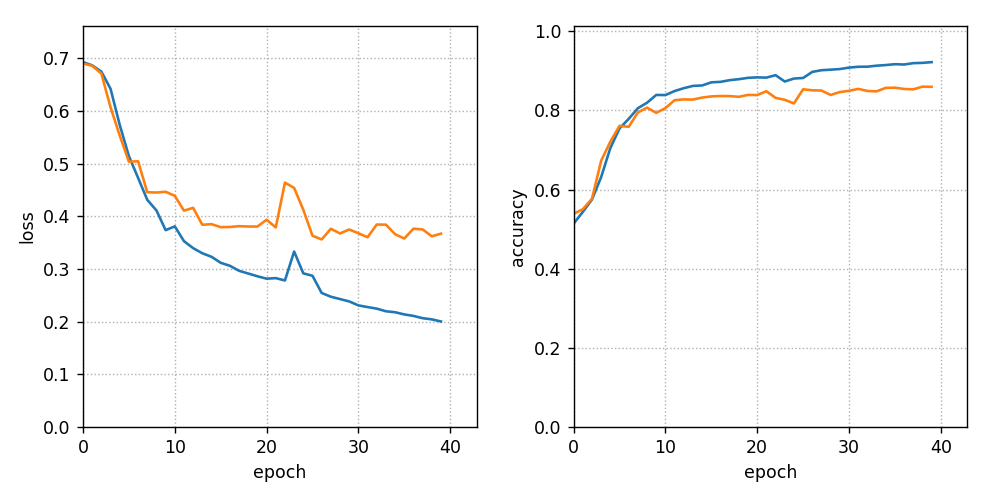

train phase
100%|██████████| 11/11 [00:21<00:00,  1.94s/it]
[Epoch 1] train accuracy: 0.5141, loss: 0.6928
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.49it/s]
[Epoch 1] eval accuracy: 0.5388, loss: 0.6903
train phase
100%|██████████| 11/11 [00:21<00:00,  1.93s/it]
[Epoch 2] train accuracy: 0.5436, loss: 0.6867
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.69it/s]
[Epoch 2] eval accuracy: 0.5504, loss: 0.6857
train phase
100%|██████████| 11/11 [00:21<00:00,  1.93s/it]
[Epoch 3] train accuracy: 0.5748, loss: 0.6748
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.63it/s]
[Epoch 3] eval accuracy: 0.5770, loss: 0.6711
train phase
100%|██████████| 11/11 [00:21<00:00,  1.94s/it]
[Epoch 4] train accuracy: 0.6318, loss: 0.6422
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.50it/s]
[Epoch 4] eval accuracy: 0.6730, loss: 0.6072
train phase
100%|██████████| 11/11 [00:21<00:00,  1.94s/it]
[Epoch 5] train accuracy: 0.7050, loss: 0.5737
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.36it

100%|██████████| 2/2 [00:01<00:00,  1.37it/s]
[Epoch 39] eval accuracy: 0.8600, loss: 0.3622
train phase
100%|██████████| 11/11 [00:21<00:00,  1.93s/it]
[Epoch 40] train accuracy: 0.9220, loss: 0.2005
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.69it/s]
[Epoch 40] eval accuracy: 0.8596, loss: 0.3672
Best validation accuracy: 0.8600
Setting rnn_module = peepholed_lstm
{'vocabulary_min_count': 100, 'vocabulary_max_size': 20000, 'review_max_length': 200, 'batch_size': 4096, 'rnn_module': 'peepholed_lstm', 'embedding_dim': 128, 'hidden_size': 100, 'learning_rate': 0.001, 'weight_decay': 0, 'epochs': 40, 'gradient_clip_norm': 1.0}
Total instances: 45000, positive: 22500, negative: 22500
Review lengths: max: 200, min: 8, mean: 168, median: 198
Vocabulary size: 4835
Using external vocabulary - vocab-related configs ignored.
Total instances: 5000, positive: 2500, negative: 2500
Review lengths: max: 200, min: 11, mean: 167, median: 195
Vocabulary size: 4835
Model Architecture:
SentimentClas

<IPython.core.display.Javascript object>


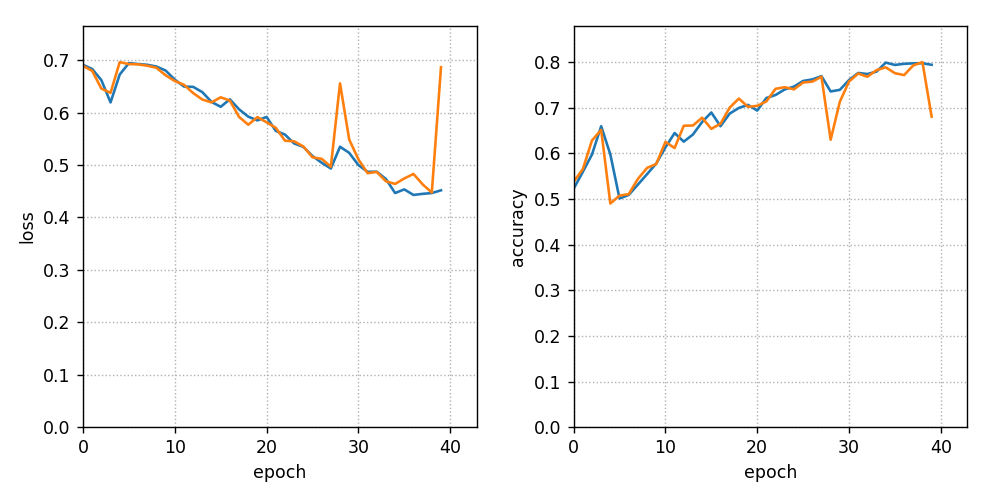

train phase
100%|██████████| 11/11 [00:21<00:00,  1.99s/it]
[Epoch 1] train accuracy: 0.5223, loss: 0.6910
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.67it/s]
[Epoch 1] eval accuracy: 0.5376, loss: 0.6890
train phase
100%|██████████| 11/11 [00:21<00:00,  1.98s/it]
[Epoch 2] train accuracy: 0.5592, loss: 0.6831
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.47it/s]
[Epoch 2] eval accuracy: 0.5652, loss: 0.6794
train phase
100%|██████████| 11/11 [00:21<00:00,  1.97s/it]
[Epoch 3] train accuracy: 0.5975, loss: 0.6618
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.68it/s]
[Epoch 3] eval accuracy: 0.6282, loss: 0.6456
train phase
100%|██████████| 11/11 [00:21<00:00,  1.97s/it]
[Epoch 4] train accuracy: 0.6594, loss: 0.6193
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.61it/s]
[Epoch 4] eval accuracy: 0.6514, loss: 0.6375
train phase
100%|██████████| 11/11 [00:21<00:00,  1.97s/it]
[Epoch 5] train accuracy: 0.5975, loss: 0.6725
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.62it

100%|██████████| 2/2 [00:01<00:00,  1.58it/s]
[Epoch 39] eval accuracy: 0.7998, loss: 0.4474
train phase
100%|██████████| 11/11 [00:21<00:00,  1.99s/it]
[Epoch 40] train accuracy: 0.7940, loss: 0.4516
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.62it/s]
[Epoch 40] eval accuracy: 0.6804, loss: 0.6864
Best validation accuracy: 0.7998
Setting rnn_module = coupled_lstm
{'vocabulary_min_count': 100, 'vocabulary_max_size': 20000, 'review_max_length': 200, 'batch_size': 4096, 'rnn_module': 'coupled_lstm', 'embedding_dim': 128, 'hidden_size': 100, 'learning_rate': 0.001, 'weight_decay': 0, 'epochs': 40, 'gradient_clip_norm': 1.0}
Total instances: 45000, positive: 22500, negative: 22500
Review lengths: max: 200, min: 8, mean: 168, median: 198
Vocabulary size: 4835
Using external vocabulary - vocab-related configs ignored.
Total instances: 5000, positive: 2500, negative: 2500
Review lengths: max: 200, min: 11, mean: 167, median: 195
Vocabulary size: 4835
Model Architecture:
SentimentClassifi

<IPython.core.display.Javascript object>


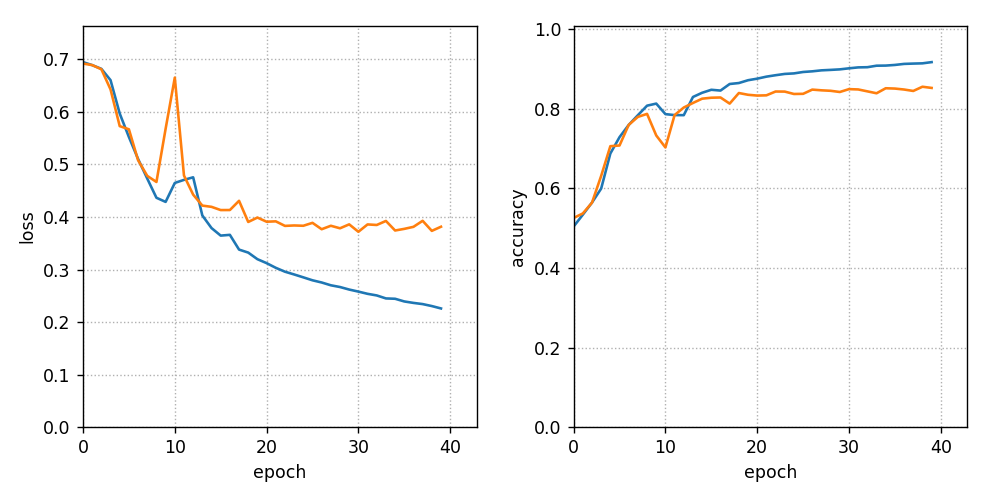

train phase
100%|██████████| 11/11 [00:20<00:00,  1.91s/it]
[Epoch 1] train accuracy: 0.5041, loss: 0.6946
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.68it/s]
[Epoch 1] eval accuracy: 0.5256, loss: 0.6919
train phase
100%|██████████| 11/11 [00:20<00:00,  1.89s/it]
[Epoch 2] train accuracy: 0.5338, loss: 0.6889
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.60it/s]
[Epoch 2] eval accuracy: 0.5370, loss: 0.6890
train phase
100%|██████████| 11/11 [00:20<00:00,  1.90s/it]
[Epoch 3] train accuracy: 0.5643, loss: 0.6819
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.46it/s]
[Epoch 3] eval accuracy: 0.5640, loss: 0.6811
train phase
100%|██████████| 11/11 [00:20<00:00,  1.90s/it]
[Epoch 4] train accuracy: 0.5995, loss: 0.6603
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.50it/s]
[Epoch 4] eval accuracy: 0.6314, loss: 0.6427
train phase
100%|██████████| 11/11 [00:20<00:00,  1.91s/it]
[Epoch 5] train accuracy: 0.6876, loss: 0.5968
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.77it

100%|██████████| 2/2 [00:01<00:00,  1.50it/s]
[Epoch 39] eval accuracy: 0.8554, loss: 0.3735
train phase
100%|██████████| 11/11 [00:20<00:00,  1.90s/it]
[Epoch 40] train accuracy: 0.9172, loss: 0.2259
eval phase
100%|██████████| 2/2 [00:01<00:00,  1.68it/s]
[Epoch 40] eval accuracy: 0.8524, loss: 0.3814
Best validation accuracy: 0.8554


<IPython.core.display.Javascript object>


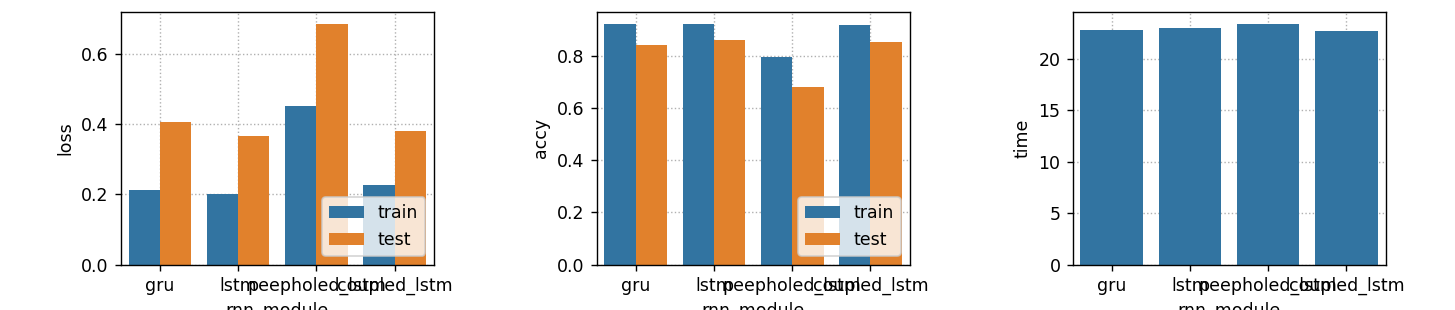

loss                accy               time     
phase              train      test     train    test      train test
rnn_module                                                          
gru             0.212565  0.407169  0.920533   0.842  22.814379  NaN
lstm            0.200538  0.367246  0.921956  0.8596  22.945476  NaN
peepholed_lstm  0.451641  0.686432  0.793978  0.6804  23.402947  NaN
coupled_lstm    0.225879  0.381409  0.917244  0.8524  22.729635  NaN

In [29]:
base_config = {
    'vocabulary_min_count': 100,
    'vocabulary_max_size': 20000,
    'review_max_length': 200,
    'batch_size': 4096,
    'rnn_module': 'gru',
    'embedding_dim': 128,
    'hidden_size': 100,
    'learning_rate': 1e-3,
    'weight_decay': 0,
    'epochs': 40,
    'gradient_clip_norm': 1.0,
}

run_experiment(
    eval_fn=imdb_trainer,
    base_config=base_config,
    var_name='rnn_module',
    var_values=['gru', 'lstm', 'peepholed_lstm', 'coupled_lstm']
)

# Language model and sentence generation

[Back to top](#Table-of-contents)

In [30]:
### Hyperparameters for training (previously defined in FLAGS)
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0
BATCH_SIZE = 4096
EPOCHS = 10

### Hyperparameters for sentence analysis model
EMBEDDING_DIM = 256
HIDDEN_SIZE = 512
RNN_MODULE = 'gru'
HISTORY_LENGTH = 100

### Hyperparameters for generating new sentence
GENERATION_LENGTH = 2000
START_STRING = 'ROMEO'
TEMPERATURE = 1.0

In [31]:
class ShakespeareDataset(Dataset):

    def __init__(self, encoded_text, history_length):
        self.encoded_text = encoded_text
        self.history_length = history_length

        raw_text = self.encoded_text.strip().decode(encoding='utf-8')

        self.vocab = sorted(set(raw_text))
        self.char2index = {x: i for (i, x) in enumerate(self.vocab)}
        self.index2char = {i: x for (i, x) in enumerate(self.vocab)}

        self.data = [
            (raw_text[i:i + history_length], raw_text[i + history_length])
                for i in range(len(raw_text) - history_length)
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        history, label = self.data[index]
        history = np.array([self.char2index[x] for x in history])
        label = self.char2index[label]
        return history, label

    def get_vocabulary(self):
        return self.vocab

dataset = ShakespeareDataset(shakespeare_text, 2)
dataset[0]

(array([18, 47]), 56)

In [32]:
class SentenceGeneration(nn.Module):

    def __init__(
        self,
        vocabulary_size,
        embedding_dim,
        rnn_module,
        hidden_size,
        bias=False
    ):
        super().__init__()
        self.vocabulary_size = vocabulary_size
        self.rnn_module = rnn_module
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.bias = bias

        self.embedding = nn.Embedding(
            num_embeddings=vocabulary_size,
            embedding_dim=embedding_dim,
            padding_idx=PADDING_TOKEN
        )
        self.rnn_model = self.rnn_module(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            bias=bias
        )
        self.classifier = nn.Linear(hidden_size, vocabulary_size)

    def forward(self, batch_text, state=None):
        data = self.embedding(batch_text)

        batch_size, total_steps, _ = data.shape
        for step in range(total_steps):
            next_state = self.rnn_model(data[:, step, :], state)
            if isinstance(next_state, tuple):
                h, c = next_state
                outputs = h
            else:
                outputs = next_state
            state = next_state

        logits = self.classifier(outputs)
        return logits, state

    def reset_parameters(self):
        with torch.no_grad:
            for param in self.parameters():
                param.reset_parameters()


In [33]:
def shakespeare_trainer(
    history_length,
    batch_size,
    embedding_dim,
    rnn_module,
    hidden_size,
    learning_rate,
    epochs,
    **kwargs
):
    train_dataset = ShakespeareDataset(
        encoded_text=shakespeare_text,
        history_length=history_length
    )
    print('Train dataset: %d' % len(train_dataset))

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )
    vocabulary = train_dataset.get_vocabulary()

    best_model = None
    best_loss = 0.0
    full_loss = []

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    model = SentenceGeneration(
        vocabulary_size=len(vocabulary),
        embedding_dim=embedding_dim,
        rnn_module=RNN_MODULES[rnn_module],
        hidden_size=hidden_size
    )
    model.to(device)

    print('Model Architecture:\n%s' % model)

    criterion = nn.CrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    plot = TrainingPlot()

    for epoch in range(epochs):
        model.train()
        dataset = train_dataset
        data_loader = train_loader

        progress_bar = tqdm(enumerate(data_loader), total=len(data_loader), file=sys.stdout)
        for step, (sequences, labels) in progress_bar:
            total_step = epoch * len(data_loader) + step
            sequences = sequences.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs, _ = model(sequences)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            corrects = torch.sum(preds == labels.data)

            loss.backward()
            optimizer.step()

            progress_bar.set_description(
                'Loss: {:.4f}, Accuracy: {:.4f}'.format(loss.item(), corrects.item() / len(labels))
            )
            full_loss.append(loss.item())
            
            plot.update_train(epoch, loss.item(), corrects.item() / len(labels))

    state_dict = {
        "model": model.cpu().state_dict(),
        "vocabulary": vocabulary
    }
    return state_dict, full_loss


In [34]:
default_config = {
    'history_length': 100,
    'batch_size': 4096,
    'rnn_module': 'gru',
    'embedding_dim': 256,
    'hidden_size': 512,
    'learning_rate': 1e-3,
    'epochs': 40,
    'generation_length': 2000,
    'temperature': 1
}

Train dataset: 1115293
Model Architecture:
SentenceGeneration(
  (embedding): Embedding(65, 256, padding_idx=0)
  (rnn_model): GRUCell(input_size=256, hidden_size=512, bias=True)
  (classifier): Linear(in_features=512, out_features=65, bias=True)
)


<IPython.core.display.Javascript object>


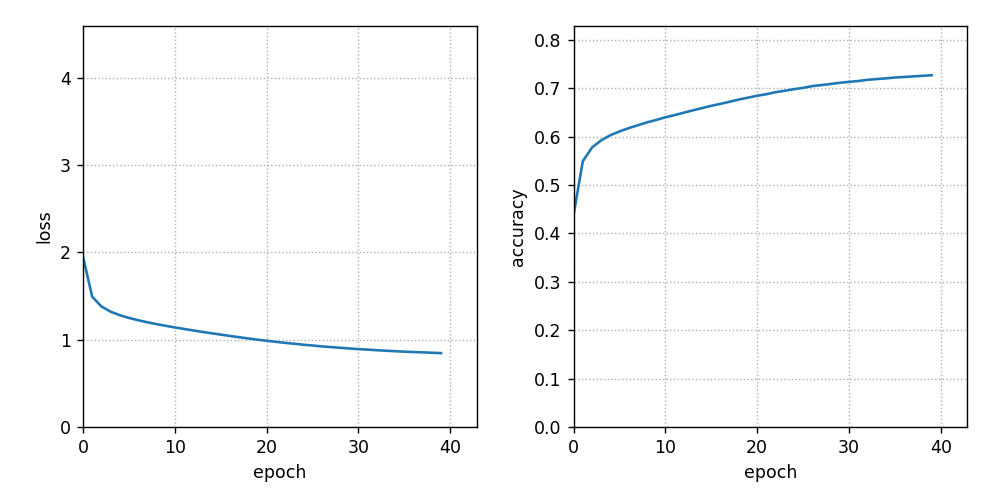

Loss: 0.8499, Accuracy: 0.7290: 100%|██████████| 273/273 [06:08<00:00,  1.35s/it]
CPU times: user 2h 30min 45s, sys: 1h 33min 20s, total: 4h 4min 6s
Wall time: 4h 6min 19s


In [35]:
%%time
final_model, loss = shakespeare_trainer(**default_config)

In [36]:
def sample_next_char_id(predicted_logits):
    next_char_id = categorical.Categorical(logits=predicted_logits).sample()
    return next_char_id

In [37]:
def shakespeare_writer(state_dict, start_string, generation_length, embedding_dim, rnn_module, hidden_size, **kwargs):
    """
    Generates new sentences using trained language model.
    """
    device = 'cpu'
    vocabulary = state_dict['vocabulary']

    char2index = {x: i for (i, x) in enumerate(vocabulary)}
    index2char = {i: x for (i, x) in enumerate(vocabulary)}

    inputs = torch.tensor([char2index[x] for x in start_string])
    inputs = inputs.view(1, -1)

    model = SentenceGeneration(
        vocabulary_size=len(vocabulary),
        embedding_dim=embedding_dim,
        rnn_module=RNN_MODULES[rnn_module],
        hidden_size=hidden_size
    )
    model.load_state_dict(state_dict['model'])
    model.eval()

    generated_chars = []
    
    for i in range(generation_length):

        outputs, _ = model(inputs)
        char_id = sample_next_char_id(outputs)
        inputs = char_id.unsqueeze(0)
        
        next_char = index2char[char_id.item()]
        generated_chars.append(next_char)

    return start_string + ''.join(generated_chars)


In [38]:
generated_text = shakespeare_writer(final_model, 'ROMEO', **default_config)
print(generated_text)

ROMEO:
 Pry; wareveshare-darinurelinonononin'sheredunonesthereresoneshareshary; Otwery VEnitherereshery:
Thederares, Ofouneres O:
gry; hetrareresthinckerararern O:
Knarededolines O, bry.
hexedonareranonuneraraly, Ashithearonaridongherwagonarereredonarererery O:
fononurerecheredererinery Manonureshary, Kit, As-veshererevedononus O, Tononithesth!
ry; hery, VI hes VI Verary, ANunesmarererurareduntusthininonory VI warmaredoninithesthary Vrily onitharestharithery, VI O:
KEn-dory; hery
Y:
douninonesthary ithemary.
arestheshereshesthery! ly,
'?
inareshererinthererenintharerararerary; qunedonitherenoninuneres VI Verery; smonones, Haresheshary Ves Preshareskerunonery; harireshestharinoninonary; sherarererery;
y, Vlatherorespherecunininononury; Vinararerery?
nitwery hary; VIs V3 O:
x, VIsharineresnurererirestherithary BUCKesty Ofunonunory theredevesthesthenithesthery:
-O:
I VExerenery mary CHary; VO:
zenedoninonininononcury; Thes harestheredonun A VE Vry:
y; anckesheritharararininithereresherinu

In [39]:
generated_text = shakespeare_writer(final_model, 'JULIET', **default_config)
print(generated_text)

JULIET:
ZAfurerinithesharinonethenary, onchery:
fonarinerinonererithestherinolonuronarorolonit, herederererery Conunininucederestharoninongoninevestheritheroreckestherininarerarariterery; VI RDonarithedononononinonarery O, G V3 VAniningritapprery
ererithary My:
RI Berestus-dareresbrery, nishareshereredestes VI Fry;
vedunonereshermary; VO, VIshery:
juninoresharernchry heres wary Ex, onesqustsmaresherary; V3 ry Mary:
V:
&Lonckery' Verereranuninty, O:
harentunininunonunarested-deshesthary.
Tharcustheshery Varery:
Lonineskerarinonithererinary hared-heves skererononarevesuredonononery, hononcherestwanewarery.
kestharenunanonarininononecheshery; Ves dinonitheshery, I VO:
Bury, Vedorery; onerirevestharerecunaronopererereduncurererorecunthery O:
zerecharerinoponary;
Nolary Cononolarereitharecesherery.
resharedeshetherithery,
ZWithery; onononinchery:
V?
&CUSunedoninoninarestherary.

Bonarerery:
-quresthestharerestherituresthary VI waronithalinaraninewarenintheshesonaralinonerinererinthesphingar